## Import

In [1]:
import os
import json
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc
import scanpy as sc
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

/home/rossi/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "output_phenotypes"

In [3]:
output_path = os.path.join(path, 'infl_vs_excl')

In [37]:
#th_path = 'figures/volcano_plots/th_75_25'
#os.makedirs("figures/volcano_plots", exist_ok=True)

## Load

In [5]:
adata = sc.read_h5ad(os.path.join(path, 'adata_phenotype.h5ad'))

In [6]:
phenotype_key = 'phenotype'
cell_type_key = 'celltype'
sample_key = 'name'
patient_key = 'patient_id'
tissue_region_key = 'tissue_region'

In [7]:
adata.X = adata.layers['counts'].copy()

In [8]:
# retain only inflamed and exluded for now
adata = adata[adata.obs[phenotype_key].isin(['inflamed', 'excluded'])].copy()

In [9]:
with open(os.path.join(path, "genes_no_source_75_25.json"), "r") as f: genes_no_source = json.load(f)

## All cells

In [10]:
adata.obs[cell_type_key].value_counts()

celltype
Cancer cell           1426606
Fibroblast             306963
Macrophage             186156
Plasma cell            158300
Endothelial cell       117303
T cell                  80569
Neutrophil              76884
Smooth muscle cell      64155
B cell                  47022
Epithelial cell         28009
Dendritic cell          15132
Mast cell                7895
Schwann cell             3758
Name: count, dtype: int64

### Counts dataframe

In [12]:
adata.obs['patient_phenotype'] = (adata.obs[patient_key].astype(str) + " - " + adata.obs[phenotype_key].astype(str))
adata.obs['patient_phenotype'] = adata.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata.X.todense() if hasattr(adata.X, "todense") else adata_cancer.X, 
                             columns=adata.var_names, 
                             index=adata.obs_names)

counts_cancer['patient_phenotype'] = adata.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [13]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 380
Genes left: 380


### Metadata dataframe

In [15]:
adata.obs[phenotype_key] = adata.obs[phenotype_key].astype('category')

metadata_cancer = adata.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [16]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [17]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.45 seconds.

Fitting dispersion trend curve...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.14 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [18]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [19]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat.summary()

Running Wald tests...
... done in 0.14 seconds.



Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A2M     1.154343e+05       -0.390536  0.299966 -1.301932  0.192940  0.641909
ACE2    1.000729e+05        0.862586  0.830617  1.038489  0.299042  0.710375
ACTA2   6.861231e+05       -0.476790  0.244304 -1.951628  0.050982  0.401882
ACTB    2.573943e+06       -0.397882  0.318177 -1.250506  0.211115  0.654633
ADAM28  1.626218e+04       -0.299002  0.479495 -0.623577  0.532905  0.843539
...              ...             ...       ...       ...       ...       ...
VEGFA   7.103740e+05       -0.271779  0.471258 -0.576709  0.564136  0.845940
VSIG4   9.576086e+03        0.055441  0.394616  0.140493  0.888270  0.963811
VSIR    4.363698e+04       -0.415054  0.313411 -1.324310  0.185400  0.639371
XBP1    6.797253e+05        0.022369  0.548793  0.040761  0.967486  0.991674
ZNF683  3.891364e+03       -0.649872  0.655519 -0.991385  0.321497  0.710375

[380 r

In [20]:
results = stat.results_df

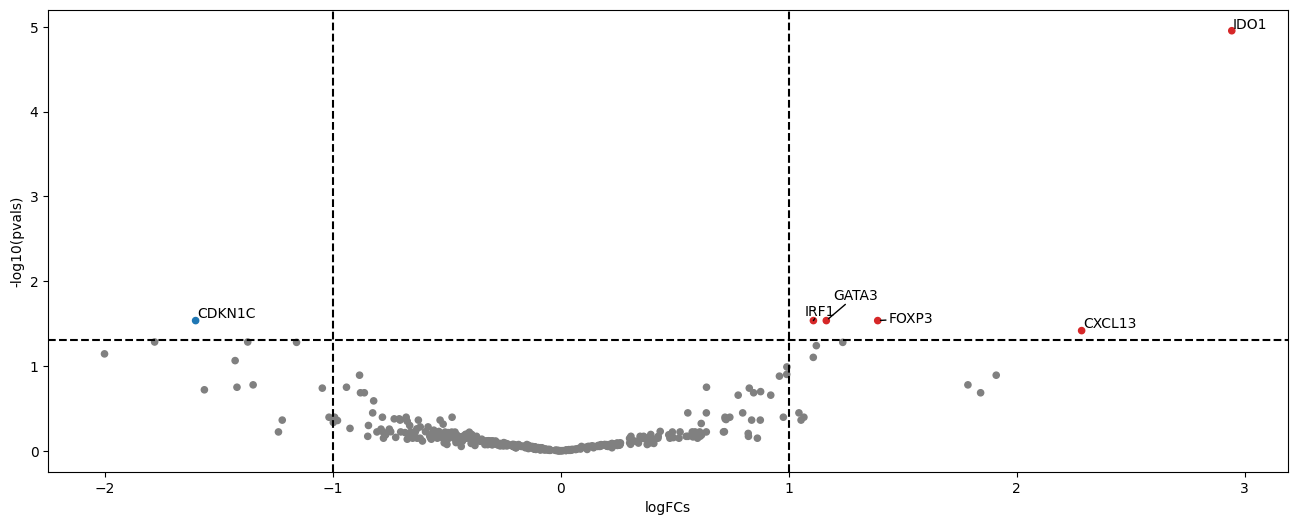

In [21]:
dc.plot_volcano_df(
    results,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=40,
    figsize=(16, 6),
    #save='volcan_cancer.png'
)

In [22]:
results.to_csv(os.path.join(output_path, "de_results.csv"), index=True)

## Cancer cell

In [23]:
adata_cancer = adata[adata.obs[cell_type_key] == "Cancer cell"].copy()

In [24]:
adata_cancer.obs[patient_key].value_counts()

patient_id
a    242006
m    149478
k    148159
j    143443
f    142024
n    131863
b    124199
e     92303
c     90544
o     84412
i     78175
Name: count, dtype: int64

### Counts dataframe

In [26]:
adata_cancer.obs['patient_phenotype'] = (adata_cancer.obs[patient_key].astype(str) + " - " + adata_cancer.obs[phenotype_key].astype(str))
adata_cancer.obs['patient_phenotype'] = adata_cancer.obs['patient_phenotype'].astype('category')

counts_cancer = pd.DataFrame(adata_cancer.X.todense() if hasattr(adata_cancer.X, "todense") else adata_cancer.X, 
                             columns=adata_cancer.var_names, 
                             index=adata_cancer.obs_names)

counts_cancer['patient_phenotype'] = adata_cancer.obs['patient_phenotype'].values
aggregated_counts = counts_cancer.groupby('patient_phenotype').sum()
aggregated_counts = aggregated_counts.astype(int)
aggregated_counts = aggregated_counts.groupby(level=0, axis=1).sum() # IMPORTANT: AGGREGATION OF DUPLICATED COLUMNS 

In [27]:
print(f"Genes: {aggregated_counts.shape[1]}")

# Filter out genes with low expression
# Keep genes with at least 10 counts in at least 3 patients
gene_keep = (aggregated_counts >= 10).sum(axis=0) >= 3
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes: 380
Genes left: 380


In [28]:
# Filter out genes which come from other sources
gene_keep = genes_no_source['Cancer cell']
aggregated_counts = aggregated_counts.loc[:, gene_keep]

print(f"Genes left: {aggregated_counts.shape[1]}")

Genes left: 265


### Metadata dataframe

In [29]:
adata_cancer.obs[phenotype_key] = adata_cancer.obs[phenotype_key].astype('category')

metadata_cancer = adata_cancer.obs.set_index('patient_phenotype')[[patient_key, phenotype_key]]

aggregated_metadata = metadata_cancer[~metadata_cancer.index.duplicated(keep='first')] # sure it is the one and only met
aggregated_metadata = aggregated_metadata.sort_index()

In [30]:
for col in aggregated_metadata.columns:
    aggregated_metadata[col] = aggregated_metadata[col].astype('category')

### DeSeq2

In [31]:
inference = DefaultInference(n_cpus=96)
dds = DeseqDataSet(
    counts=aggregated_counts,
    metadata=aggregated_metadata,
    design_factors=['phenotype'],
    refit_cooks=True,
    inference=inference,
)

In [32]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.41 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.08 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [33]:
#dds.write(os.path.join(path, 'deseq.h5ad'))

In [34]:
# default: alpha=0.05, cooks_filter=True, independent_filter=True
stat_cancer = DeseqStats(dds, contrast=["phenotype", 'inflamed', 'excluded'], inference=inference)
stat_cancer.summary()

Log2 fold change & Wald test p-value: phenotype inflamed vs excluded
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
ACE2    9.889546e+04        0.954472  0.902838  1.057191  0.290424  0.759499
ACTA2   3.414125e+05       -0.313920  0.260614 -1.204541  0.228380  0.728222
ACTB    1.961462e+06       -0.248440  0.289990 -0.856720  0.391600  0.833251
ADAM28  7.828157e+03        0.188463  0.665595  0.283149  0.777062  0.928019
AIRE    2.799993e+03        1.557256  0.920014  1.692644       NaN       NaN
...              ...             ...       ...       ...       ...       ...
TUBB    1.539291e+05       -0.139818  0.371237 -0.376626  0.706451  0.916560
TXLNA   1.146697e+05       -0.077865  0.351711 -0.221390  0.824788  0.946772
UBE2C   1.470451e+05        0.536560  0.379411  1.414192  0.157306  0.677221
VSIR    2.059423e+04       -0.679173  0.484917 -1.400596  0.161335  0.677221
XBP1    6.012198e+05        0.322746  0.614242  0.525438  0.599279  0.895663

[265 r

Running Wald tests...
... done in 0.09 seconds.



In [35]:
results_cancer = stat_cancer.results_df

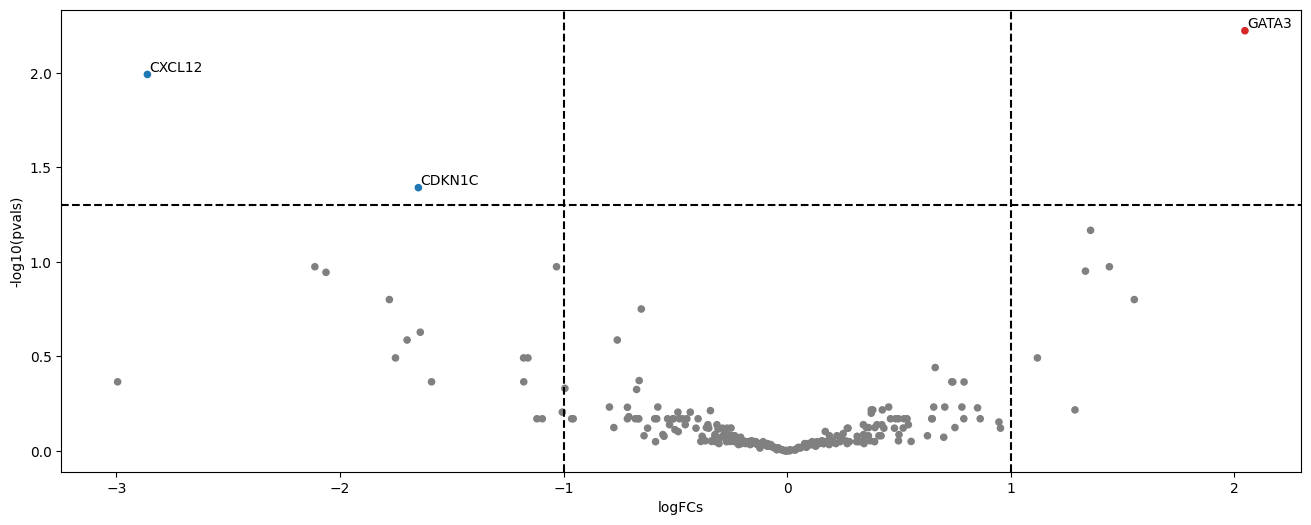

In [36]:
dc.plot_volcano_df(
    results_cancer,
    x='log2FoldChange', lFCs_thr=1,
    y='padj',
    top=60,
    figsize=(16, 6),
    #save='volcan_cancer.png'
)

In [37]:
results_cancer.to_csv(os.path.join(output_path, "de_results_cancer.csv"), index=True)